# Gold Mining Project

## Introduction

In collaboration with Zyfra, a company renowned for its efficiency solutions in heavy industry, this project focuses on developing a machine learning model to predict gold recovery from ore. The objective is to optimize production and eliminate unprofitable parameters by accurately forecasting the amount of gold recovered during the extraction and purification processes.

### Project Overview

**Objective:**
The primary goal is to create a prototype machine learning model capable of predicting gold recovery from gold ore. The model will utilize historical data on gold extraction and purification to provide valuable insights that can enhance operational efficiency and profitability.

**Scope:**
The project will involve three main stages: data preparation, data analysis, and model development and training. First, we will organize and preprocess the data to ensure it is suitable for analysis and modeling. Next, we will perform thorough data analysis to understand the underlying patterns and relationships within the data. Finally, we will develop and train a predictive model using advanced machine learning techniques.

**Targets**
The model aims to predict two specific metrics: the rougher concentrate recovery (`rougher.output.recovery`) and the final concentrate recovery (`final.output.recovery`). By accurately forecasting these values, the model will help Zyfra optimize the gold recovery process, improving both efficiency and profitability in their operations.

### Methodology

**Process Flow:** The process of gold recovery begins with primary processing, where mined ore is initially processed to produce a rougher feed, which serves as the raw material for the flotation process. During flotation, the rougher feed is processed to separate gold from the ore, resulting in a rougher concentrate. This rougher concentrate then undergoes a two-stage purification process to further increase gold purity.

**Recovery Calculation**
To simulate the gold recovery process, we will use a specific formula that considers the shares of gold in the concentrate, feed, and tails. The recovery formula is:

$$Recovery = C × (F − T) / F × (C − T)$$
where:
- C is the share of gold in the concentrate
- F is the share of gold in the feed
- T is the share of gold in the tails

Both the rougher concentrate recovery and the final concentrate recovery are crucial for predicting the overall recovery efficiency.

**Evaluation Metric:** The model's performance will be evaluated using the symmetric Mean Absolute Percentage Error (sMAPE). This metric considers both the target and predicted values symmetrically, ensuring that the model's predictions are assessed in a relative context. sMAPE is calculated as follows:

$$ sMAPE = (1 / N) * Σ(|target_i - prediction_i| / ((target_i + prediction_i) / 2) * 100)$$

where:

- $target_𝑖$ is the actual value for the i-th observation
- $prediction_𝑖$ is the predicted value for the i-th observation
- $𝑁$ is the total number of observations

### Tools & Documentation

To accomplish these tasks, the project will leverage various Python libraries and their documentation, including pandas for data manipulation and analysis, matplotlib for data visualization, and scikit-learn (sklearn) for machine learning model development and evaluation. This structured approach ensures a comprehensive solution to predicting gold recovery, ultimately aiding Zyfra in enhancing their production processes.

## Setup

### Library Import

In [1]:
import pandas as pd
import numpy as np
import statistics
import math
from scipy import stats as st
from matplotlib import pyplot as plt
from pprint import pprint

# Sklearn modules
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Sklearn modules - models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Options
pd.options.mode.chained_assignment = None

### Import datasets

In [2]:
try:
    train_data = pd.read_csv("./data/gold_recovery_train.csv")
    test_data = pd.read_csv("./data/gold_recovery_test.csv")
    full_data = pd.read_csv("./data/gold_recovery_full.csv")
except FileNotFoundError as f_error:
    print(f"The following error: ({f_error}) occured while loading datasets")
else:
    test_data.name = "Test Data"
    train_data.name = "Train Data"
    full_data.name = "Full Data"
    print("The data was sucessfully loaded")

The data was sucessfully loaded


## Data Preparation

In [3]:
# Look at dataset

datasets = [train_data, test_data, full_data]
for dataset in datasets:
    print("==============================", dataset.name, "==============================\n")
    dataset.info()
    print()
    

============================== Train Data ==============================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   fi

**Findings**

The three datasets differ in the number of columns: the train dataset and the full dataset each have 87 columns, while the test dataset has only 53 columns. For model development, it's crucial to remove any features from the train and full datasets that are not present in the test dataset. Including features in the training process that 
aren't available during testing would negatively impact the model's performance.

Many columns in each of the three datasets contain missing values. These will need further investigation to determine the best approach for handling them.

### Handle Missing Values

In [4]:
# Look at missing values

with pd.option_context('display.max_rows', None):
    for dataset in datasets:
        print("==============================", dataset.name, "==============================\n")
        print(dataset.isna().sum()) 
        print()

============================== Train Data ==============================

date                                                     0
final.output.concentrate_ag                             72
final.output.concentrate_pb                             72
final.output.concentrate_sol                           370
final.output.concentrate_au                             71
final.output.recovery                                 1521
final.output.tail_ag                                    66
final.output.tail_pb                                   183
final.output.tail_sol                                  145
final.output.tail_au                                    66
primary_cleaner.input.sulfate                         1307
primary_cleaner.input.depressant                      1262
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         985
primary_cleaner.output.concentrate_ag                   82
primary_cleaner.output.concentrate_pb    

In [5]:
# Determine the percentage of data missing in each column

with pd.option_context('display.max_rows', None):
    missing_percentages = []
    for dataset in datasets:
        print("==============================", dataset.name, "==============================\n")
        # Calculate the percentage that the number of missing values equates to for each column
        missing_percentage_cols = round((dataset.isna().sum() / dataset.shape[0] * 100), 2)
        missing_percentages.append(missing_percentage_cols.tolist())
        print(missing_percentage_cols)
        print()

============================== Train Data ==============================

date                                                   0.00
final.output.concentrate_ag                            0.43
final.output.concentrate_pb                            0.43
final.output.concentrate_sol                           2.19
final.output.concentrate_au                            0.42
final.output.recovery                                  9.02
final.output.tail_ag                                   0.39
final.output.tail_pb                                   1.09
final.output.tail_sol                                  0.86
final.output.tail_au                                   0.39
primary_cleaner.input.sulfate                          7.75
primary_cleaner.input.depressant                       7.49
primary_cleaner.input.feed_size                        0.00
primary_cleaner.input.xanthate                         5.84
primary_cleaner.output.concentrate_ag                  0.49
primary_cleaner.output.con

In [6]:
# Find the number of columns that have more than 5% of data missing

for i in range(len(missing_percentages)):
    count = 0
    for j in range(len(missing_percentages[i])):
        if missing_percentages[i][j] > 5:
            count += 1
    
    missing_percentages[i] = count # Reassigning the count to the poisition of the original array

print(missing_percentages)

[12, 2, 12]


**Findings**

The train (index 0) and full (index 2) datasets each have 12 columns with more than 5% of their values missing. In contrast, the test (index 1) dataset has only 2 columns with more than 5% of their values missing.

Removing the missing values from the train dataset would result in losing about one-third of the data. Given the large number of columns with missing data, and considering that out of the 86 columns with missing data, only about 12 have more than 5% missing, dropping missing targets and forward filling the missing values is a viable option. This avoids the need to use the mean or median for imputation. The same approach will be applied to the test and full datasets.

In [7]:
# Drop missing targets from each dataset

targets = ['rougher.output.recovery', 'final.output.recovery']

if set(targets).issubset(train_data.columns):
    train_data = train_data.dropna(subset=targets)
if set(targets).issubset(test_data.columns):
    test_data = test_data.dropna(subset=targets)
if set(targets).issubset(full_data.columns):
    full_data = full_data.dropna(subset=targets)

In [8]:
# Forward fill each missing value with the last known value

train_data = train_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')
full_data = full_data.fillna(method='ffill')

datasets = [train_data, test_data, full_data] # Add each dataset back into the datasets array

/var/folders/lv/184f2v754m72c6dvppckg1540000gn/T/ipykernel_8242/3808212882.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='ffill')
/var/folders/lv/184f2v754m72c6dvppckg1540000gn/T/ipykernel_8242/3808212882.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(method='ffill')
/var/folders/lv/184f2v754m72c6dvppckg1540000gn/T/ipykernel_8242/3808212882.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_data = full_data.fillna(method='ffill')


### Handle Duplicated Values

In [9]:
# Look for duplicated values

print(train_data.duplicated().sum())
print(test_data.duplicated().sum())
print(full_data.duplicated().sum())

0
0
0


**Findings**

None of the three datasets contain duplicate values.

### Accuracy of Recovery Calculation

The accuracy of the actual `rougher.output.recovery` value should be assessed. This evaluation involves using mean absolute error analysis to compare the predicted recovery values with the actual recovery values and determine the accuracy of the results.

In [10]:
# Function to calculate recovery

def calculate_recovery(data, calc_type="rougher"):
    '''Returns the input dataframe with a {calc_type}.calculated.recovery column for either the rougher or 
    final yield (default is 'rougher') and a Pandas Series containing the recovery values.
    Recovery is calculated using the following equation: ((C * (F-T)) / (F * (C-T))) * 100. '''
    
    C = data[f'{calc_type}.output.concentrate_au']
    T = data[f'{calc_type}.output.tail_au']
    F = data['rougher.input.feed_au'] if calc_type == "rougher" else data['rougher.output.concentrate_au']
    
    recovery = ((C * (F-T)) / (F * (C-T))) * 100
    
    print(f"===== Calculated Recovery for '{calc_type}'===== \n{recovery}")
    
    # Add recovery to the dataframe
    data[f'{calc_type}.calculated.recovery'] = recovery
    
    # Replace two infinity values with 0 (if needed)
    data[f'{calc_type}.calculated.recovery'].replace([np.inf, -np.inf], np.nan, inplace=True)

    return data, recovery


In [11]:
# Calculate the rougher recovery
train_data, predicted_recovery_values = calculate_recovery(train_data.dropna(subset=['rougher.output.recovery']), calc_type="rougher")

# Grab values for actual recovery
actual_recovery_values = train_data['rougher.output.recovery']

print()
print(f"=====Actual Recovery for 'rougher'===== ")
actual_recovery_values


===== Calculated Recovery for 'rougher'===== 
0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 14149, dtype: float64

=====Actual Recovery for 'rougher'===== 


0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

In [12]:
# Check number of missing values for each feature

print(actual_recovery_values.isna().sum())
print(predicted_recovery_values.isna().sum())

0
0


In [13]:
# Drop columns where values are missing from the calculated column
train_data = train_data.dropna(subset=['rougher.calculated.recovery'])

# Reassign to existing variables 
actual_recovery_values = train_data['rougher.output.recovery']
predicted_recovery_values = train_data['rougher.calculated.recovery']


In [14]:
# Calculate MAE
mae = mean_absolute_error(actual_recovery_values, predicted_recovery_values)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 9.317053768151204e-15


**Findings**

The Mean Absolute Error (MAE) value when comparing the actual recovery values from the dataset with the predicted recovery values was approximately `9.317053768151204e-15` (`0.000000000000009317053768151204`). This extremely low MAE indicates that the actual recovery values in the training dataset are highly accurate. Since the MAE is so close to zero, it can be concluded that the actual values are nearly perfect.

### Feature Comparison (Train & Test Datasets)

In [15]:
# Find features available in the train dataset but not in test dataset

train_cols = train_data.columns.tolist()
test_cols = test_data.columns.tolist()
missing_cols = []

for col in train_cols:
    if col not in test_cols:
        missing_cols.append(col)

print(f"Columns present in Train Dataset but not in Test Dataset: [Total Number = {len(missing_cols)}]")
pprint(missing_cols)

Columns present in Train Dataset but not in Test Dataset: [Total Number = 35]
['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recove

**Findings**

The 35 features missing from the test datasets are related to the outputs of the ore mining process. Specifically, the outputs of silver (Ag), lead (Pb), gold (Au), and colloidal gold (sol) for the concentrate and tail at each stage (rougher, primary cleaner, secondary cleaner, and final) are all absent from the test dataset.

## Data Analysis

### Changes in Metal Concentrations

In [16]:
# Observe changes in concentration for different metals

metal_cols = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag',
              'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb',
              'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'
             ]

metal_data = train_data[metal_cols]
metal_data


,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
0,11.500771,8.547551,6.055403,7.101074,10.389648,9.889648,19.793808,34.174427,42.192020
1,11.615865,8.558743,6.029369,7.278807,10.497069,9.968944,20.050975,34.118526,42.701629
2,11.695753,8.603505,6.055926,7.216833,10.354494,10.213995,19.737170,33.969464,42.657501
3,11.915047,7.221879,6.047977,7.175616,8.496563,9.977019,19.320810,28.260743,42.689819
4,12.411054,9.089428,6.148599,7.240205,9.986786,10.142511,19.216101,33.044932,42.774141
...,...,...,...,...,...,...,...,...,...
16855,11.124896,6.559174,3.224920,10.984003,12.445966,11.356233,18.603550,32.940215,46.713954
16856,11.425983,6.612376,3.195978,10.888213,12.623947,11.349355,18.441436,32.925325,46.866780
16857,8.523497,7.128896,3.109998,8.955135,12.633558,11.434366,15.111231,31.856742,46.795691
16858,11.658799,7.490444,3.367241,10.655377,12.012378,11.625587,17.834772,30.770892,46.408188


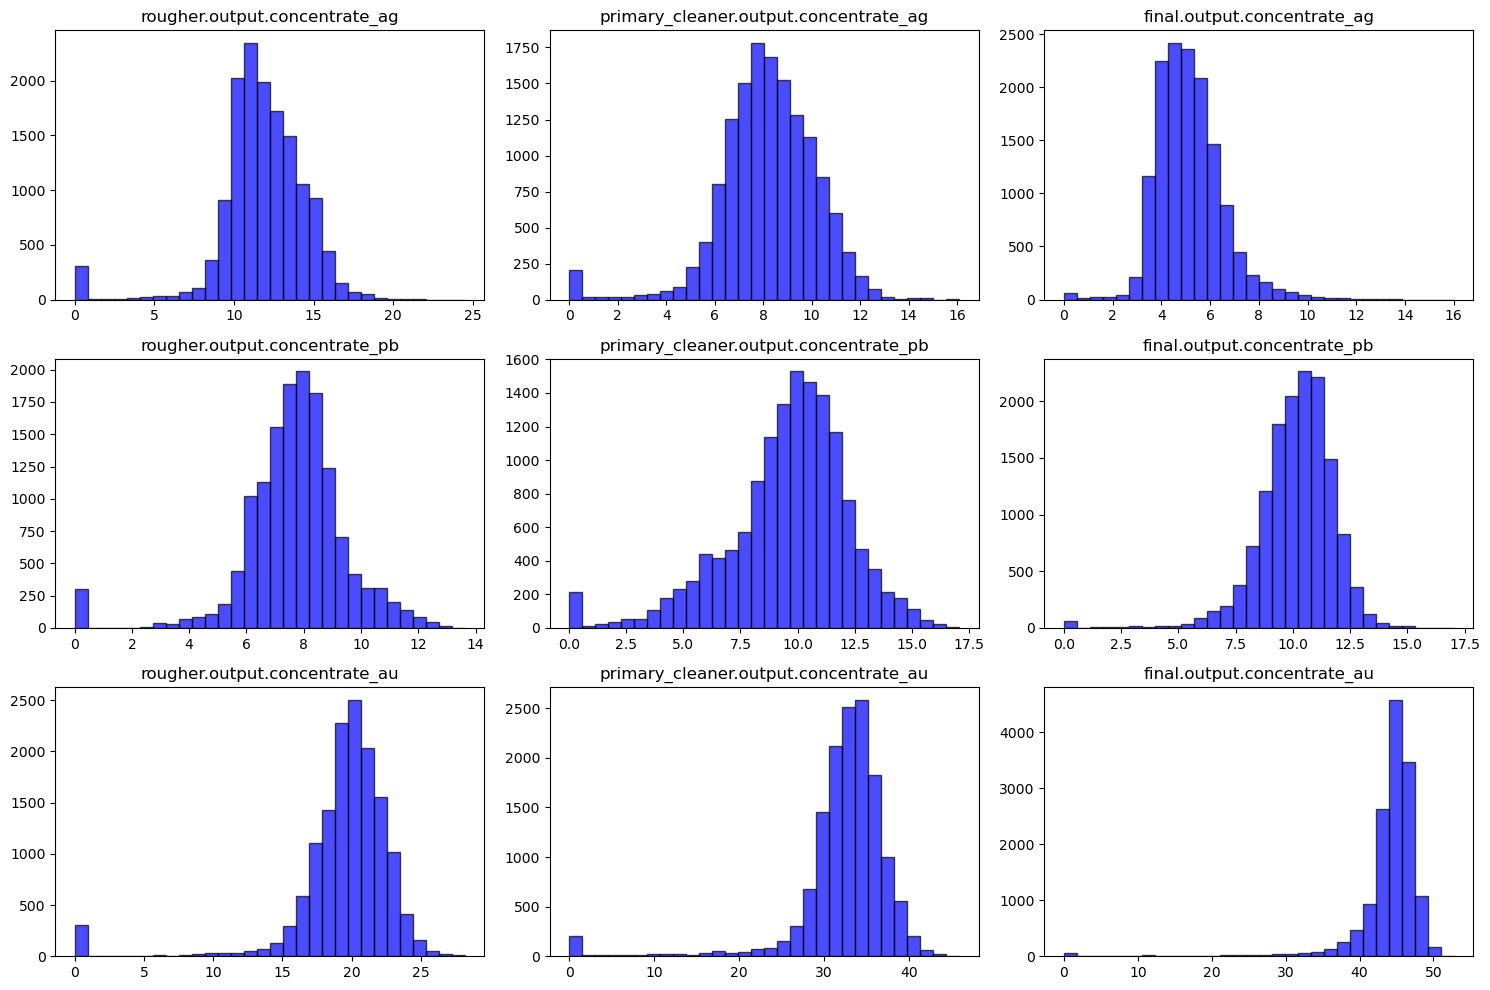

In [17]:
plt.figure(figsize=(15, 10))

for i in range(len(metal_cols)):
    col = metal_cols[i]
    plt.subplot(3, 3, i + 1)
    plt.hist(metal_data[col].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(col)
    plt.tight_layout()

plt.show()

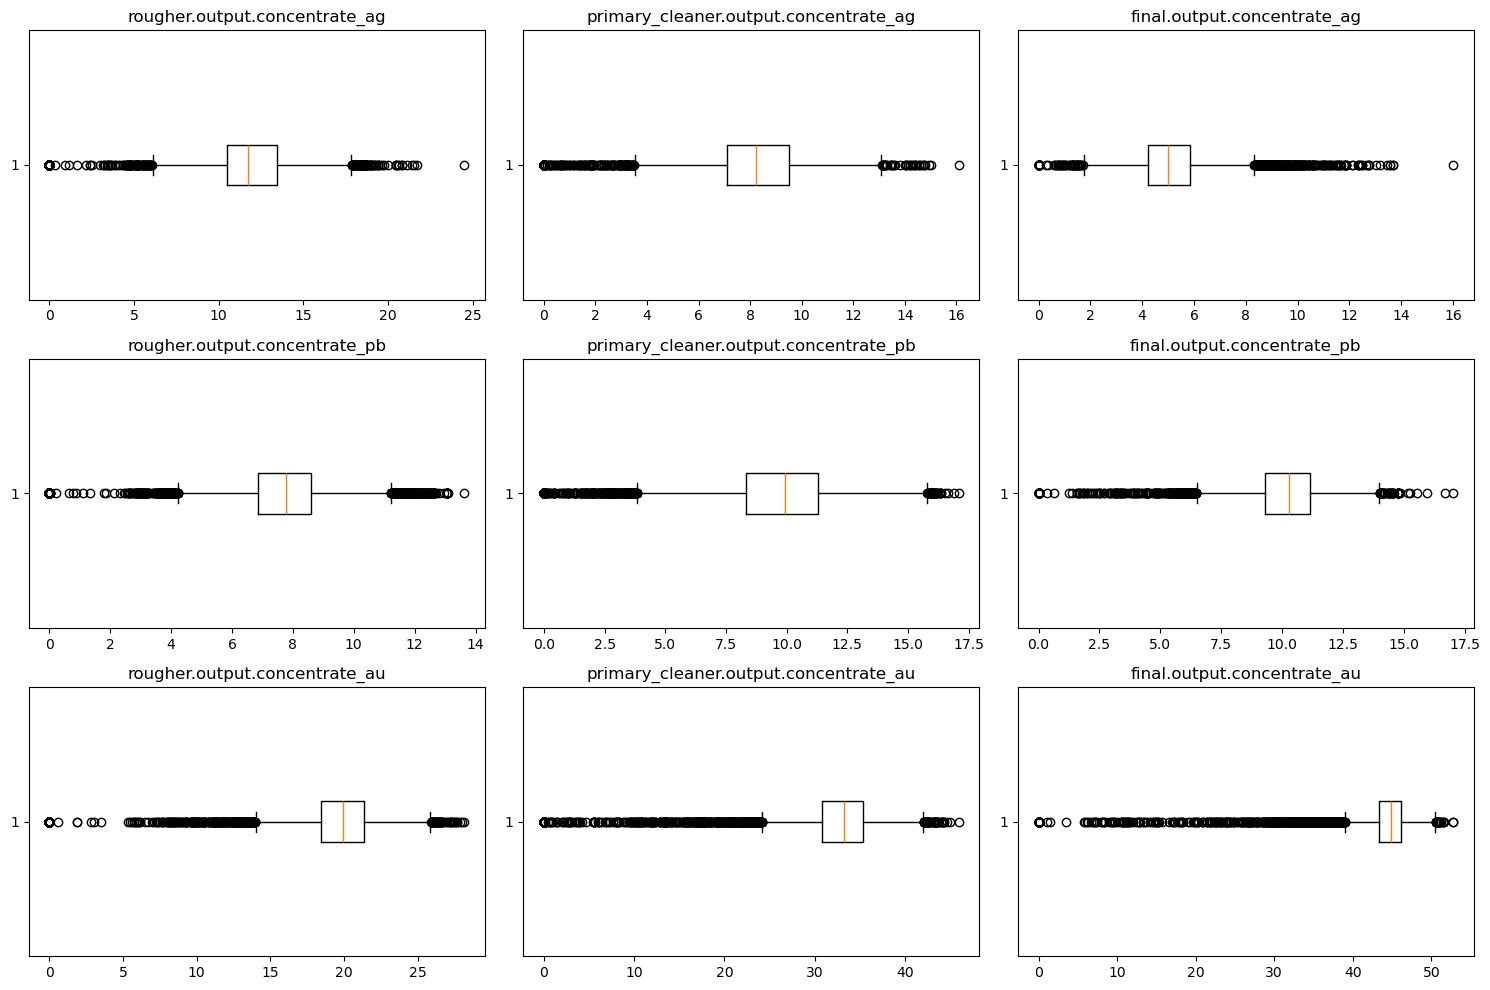

In [18]:
plt.figure(figsize=(15, 10))
for i in range(len(metal_cols)):
    col = metal_cols[i]
    plt.subplot(3, 3, i + 1)
    plt.boxplot(metal_data[col].dropna(), vert=False)
    plt.title(col)
    plt.tight_layout()

plt.show()

**Findings**

The concentration output for different metals varies throughout the two stages of the purification process:

- **Silver (Ag):** The concentration of silver generally decreases after each stage of the purification process (primary cleaner and secondary cleaner).
- **Lead (Pb):** The concentration of lead slightly increases after the primary cleaner but then slightly decreases after the secondary cleaner stage. The final concentration tends to be slightly higher than the concentration prior to the purification processes.
- **Gold (Au):** The concentration of gold tends to increase after each step of the purification process, with a significant increase after the primary cleaner stage and a smaller increase after the secondary cleaner stage.

### Feed particle size distributions



Before evaluating the model, it's crucial to compare the feed particle size distributions in both the training and test datasets. Any notable differences in these distributions could potentially lead to inaccurate model evaluation. Thus, it's essential to ensure consistency between the training and test data to maintain the model's reliability during evaluation.

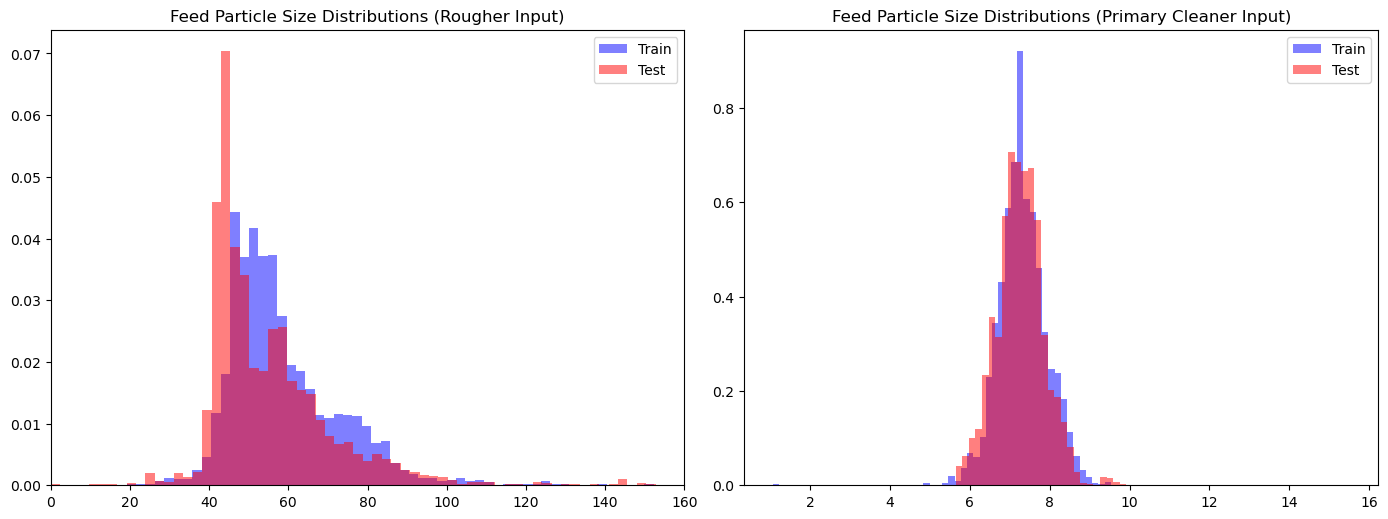

In [19]:
# Train feed size cols
rougher_feed_size_train = train_data['rougher.input.feed_size']
primary_cleaner_feed_size_train = train_data['primary_cleaner.input.feed_size']

# Test feed size cols
rougher_feed_size_test = test_data['rougher.input.feed_size']
primary_cleaner_feed_size_test = test_data['primary_cleaner.input.feed_size']

# Create figure for plots
plt.figure(figsize=(14, 10))

# Histogram for Rougher Feed Size
plt.subplot(2, 2, 1)
plt.hist(rougher_feed_size_train, bins=200, alpha=0.5, density=True, label='Train', color='blue')
plt.hist(rougher_feed_size_test, bins=200, alpha=0.5, density=True, label='Test', color='red')
plt.legend(loc='upper right')
plt.title('Feed Particle Size Distributions (Rougher Input)')
plt.xlim(0, 160)

# Histogram for Primary Cleaner Feed Size
plt.subplot(2, 2, 2)
plt.hist(primary_cleaner_feed_size_train, bins=60, alpha=0.5, density=True, label='Train', color='blue')
plt.hist(primary_cleaner_feed_size_test, bins=60, alpha=0.5, density=True, label='Test', color='red')
plt.legend(loc='upper right')
plt.title('Feed Particle Size Distributions (Primary Cleaner Input)')

plt.tight_layout()
plt.show()

In [20]:
# Calculate emperical distribution function (ECDF)

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
 
    # x-data for the ECDF: x
    x = np.sort(data)
 
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
 
    return x, y

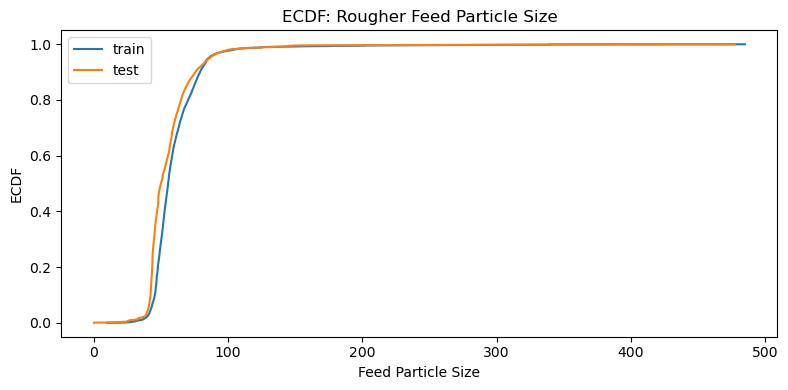

In [21]:
# Calculate ECDF for Rougher

eCDF_rougher_train_x, eCDF_rougher_train_y = ecdf(rougher_feed_size_train)
eCDF_rougher_test_x, eCDF_rougher_test_y = ecdf(rougher_feed_size_test)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(eCDF_rougher_train_x, eCDF_rougher_train_y, label="train")
ax.plot(eCDF_rougher_test_x, eCDF_rougher_test_y, label="test")
ax.legend()

plt.title('ECDF: Rougher Feed Particle Size')
plt.xlabel('Feed Particle Size')
plt.ylabel('ECDF')
fig.tight_layout()

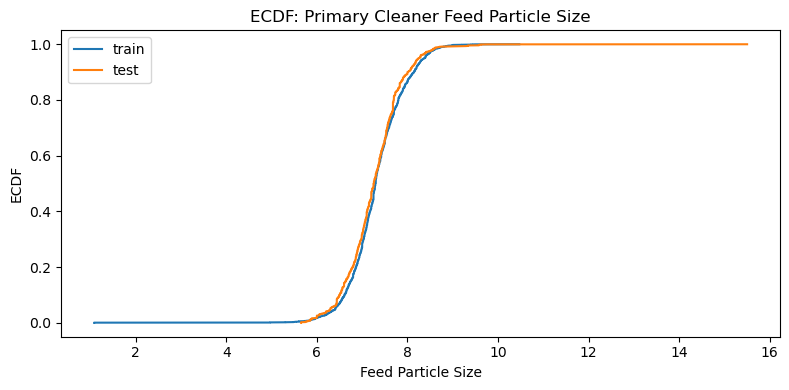

In [22]:
# Calculate ECDF for Primary Cleaner

eCDF_pc_train_x, eCDF_pc_train_y = ecdf(primary_cleaner_feed_size_train)
eCDF_pc_test_x, eCDF_pc_test_y = ecdf(primary_cleaner_feed_size_test)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(eCDF_pc_train_x, eCDF_pc_train_y, label="train")
ax.plot(eCDF_pc_test_x, eCDF_pc_test_y, label="test")
ax.legend()


plt.title('ECDF: Primary Cleaner Feed Particle Size')
plt.xlabel('Feed Particle Size')
plt.ylabel('ECDF')
fig.tight_layout()

**Findings**

Upon examining histogram distribution plots of particle feed size in the train dataset for both input feeds (`rougher.input.feed_size` and `primary.cleaner.input.feed_size`), and comparing them to the test dataset, it can be deduced that there are no significant disparities in the distributions of these datasets. Furthermore, the empirical cumulative distribution function (ECDF) analysis did not yield evidence of a substantial Kolmogorov-Smirnov statistic between the two datasets.

### Total concentrations of all substances at different stages

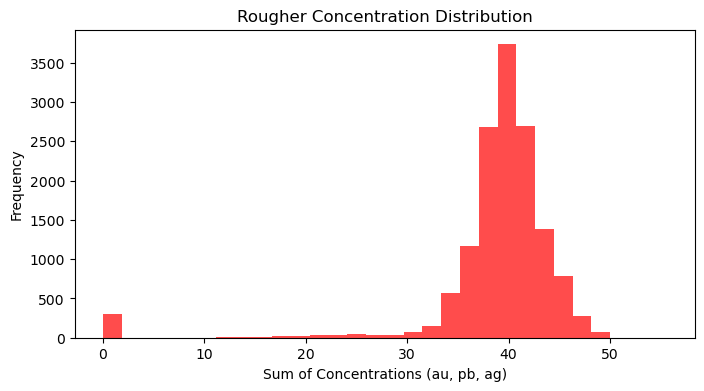

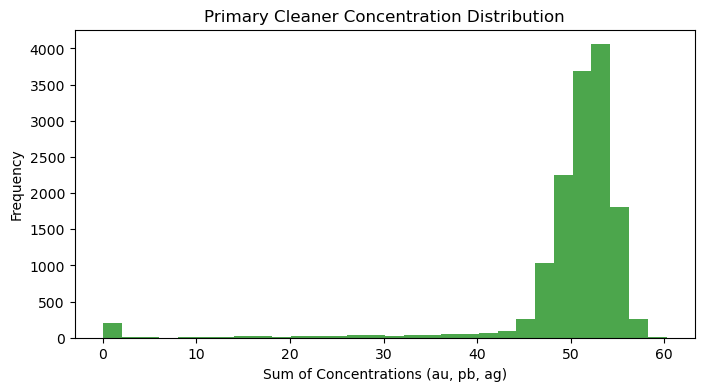

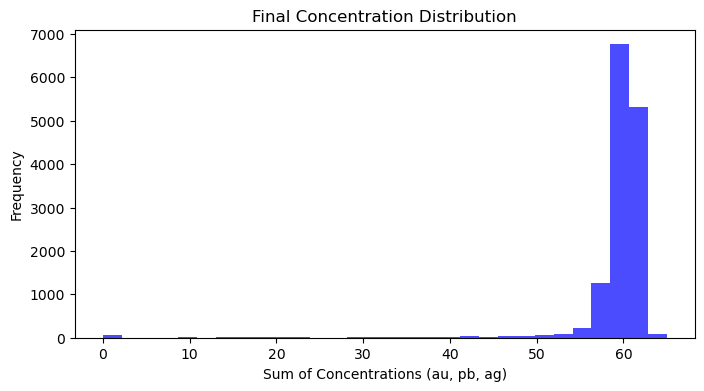

In [23]:
# Calculate the sums of concentrations for metal
final_conc = train_data['final.output.concentrate_ag'] + train_data['final.output.concentrate_pb'] + train_data['final.output.concentrate_au']
pc_conc = train_data['primary_cleaner.output.concentrate_ag'] + train_data['primary_cleaner.output.concentrate_pb'] + train_data['primary_cleaner.output.concentrate_au']
rougher_conc = train_data['rougher.output.concentrate_ag'] + train_data['rougher.output.concentrate_pb'] + train_data['rougher.output.concentrate_au']

# Rougher Concentrations
plt.figure(figsize=(8, 4)) 
plt.hist(rougher_conc, bins=30, color='red', alpha=0.7)
plt.title('Rougher Concentration Distribution')
plt.xlabel('Sum of Concentrations (au, pb, ag)')
plt.ylabel('Frequency')

# Primary Cleaner Concentrations
plt.figure(figsize=(8, 4))
plt.hist(pc_conc, bins=30, color='green', alpha=0.7)
plt.title('Primary Cleaner Concentration Distribution')
plt.xlabel('Sum of Concentrations (au, pb, ag)')
plt.ylabel('Frequency')

# Final Concentrations
plt.figure(figsize=(8, 4))
plt.hist(final_conc, bins=30, color='blue', alpha=0.7)
plt.title('Final Concentration Distribution')
plt.xlabel('Sum of Concentrations (au, pb, ag)')
plt.ylabel('Frequency')

plt.show()

**Findings**

As the processing advances through various stages, the cumulative concentrations of each metal (gold, lead, silver) typically rise. Furthermore, the concentration distributions exhibit a pronounced leftward skew as we progress through the stages of the process.

## Model Preparation

### Prepare train and test data for model

The date column is not necessary for the model. This will be dropped and a new index will be used for the dataset.

In [24]:
# Drop the date column 

train_data_final = train_data.drop(['date'], axis=1).reset_index(drop=True)

As previously noted, the training data includes numerous additional columns that are absent from the test dataset, potentially leading to target leakage. To prevent this, any columns not present in the test dataset will be excluded from the final set of training features.

In [25]:
# Define the train target & features

## Declare the two targets
y_train = train_data_final[['rougher.output.recovery', 'final.output.recovery']]

# Declare the features and remove missing columns
X_train = train_data_final.drop(missing_cols, axis=1)

The various features in the dataset are represented on different scales. To optimize the model, these features should be standardized to a common scale.

In [26]:
# Feature scaling

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

### Function Definitions

In [27]:
# Function to calculate sMAPE

def calculate_smape(y, yhat):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (sMAPE) using the 
    following equation: SMAPE = (1/n) * Σ(|yi – yhati| / ((|yi| + |yhati|)/2) * 100
    
    Parameters:
    y: Actual values.
    yhat: Predicted values.
    
    Returns:
    float: sMAPE value.
    """
    
    N = len(y)
    smape = (1 / N) * np.sum(2 * np.abs(y - yhat) / (np.abs(y) + np.abs(yhat))) * 100
    return smape

In [28]:
# Function to calculate final sMAPE

def calculate_fsmape(y, ypred):
    """
    Calculate the final sMAPE by combining the sMAPE values for rougher and final stages using the 
    following equation: 25% * sMAPE(rougher) + 75% * sMAPE(final)
    
    Parameters:
    rougher_smape (float): sMAPE value for the rougher stage.
    final_smape (float): sMAPE value for the final stage.
    
    Returns:
    float: Final sMAPE value.
    """
    
    rougher_smape = calculate_smape(y.iloc[:, 0], ypred[:, 0])
    final_smape = calculate_smape(y.iloc[:, 1], ypred[:, 1])
    
    fsmape = (0.25 * rougher_smape) + (0.75 * final_smape)
    return fsmape


In [29]:
def smape_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return calculate_fsmape(y_true.T, y_pred.T)

## Train Models

### Linear Regression

In [30]:
model = LinearRegression()

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lr_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=smape_scorer)
lr_score = lr_scores.mean()

print(f"Linear Regression: score = {lr_score}")

Linear Regression: score = 6.152887026747681


### Decision Tree

In [31]:
dt_scores_raw = []
dt_scores = []

for depth in range(1, 11):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', DecisionTreeRegressor(max_depth=depth, random_state=123))
    ])
    
    dt_score = (cross_val_score(pipeline, X_train, y_train, cv=10, scoring=smape_scorer))
    dt_scores_raw.append(dt_score)
    dt_scores.append(dt_score.mean())
    
    print(f"{depth}: Decision Tree: depth = {depth},", "score =", dt_score.mean())

1: Decision Tree: depth = 1, score = 7.860560961352239
2: Decision Tree: depth = 2, score = 7.619719843560581
3: Decision Tree: depth = 3, score = 6.320037761456557
4: Decision Tree: depth = 4, score = 7.15057754336692
5: Decision Tree: depth = 5, score = 6.732118769803288
6: Decision Tree: depth = 6, score = 6.555375802935684
7: Decision Tree: depth = 7, score = 6.808783028077198
8: Decision Tree: depth = 8, score = 6.339441084765253
9: Decision Tree: depth = 9, score = 6.147801050841229
10: Decision Tree: depth = 10, score = 5.868055107222169


### Random Forest

In [32]:
rf_scores_raw = []
rf_scores = []

for est in range(1, 31, 15):
    for depth in range(1, 6):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=123))
        ])
        
        rf_score = (cross_val_score(pipeline, X_train, y_train, cv=10, scoring=smape_scorer))
        rf_scores_raw.append(rf_score)
        rf_scores.append(rf_score.mean())
        
        print(f"{depth}: Random Forest: depth = {depth},", f"estimators = {est}", "score =", rf_score.mean())


1: Random Forest: depth = 1, estimators = 1 score = 7.627317235311454
2: Random Forest: depth = 2, estimators = 1 score = 7.598576419855472
3: Random Forest: depth = 3, estimators = 1 score = 5.994904978830915
4: Random Forest: depth = 4, estimators = 1 score = 6.53660143077808
5: Random Forest: depth = 5, estimators = 1 score = 6.744460105352275
1: Random Forest: depth = 1, estimators = 16 score = 7.646360450000364
2: Random Forest: depth = 2, estimators = 16 score = 7.112270012373986
3: Random Forest: depth = 3, estimators = 16 score = 6.2564224076934565
4: Random Forest: depth = 4, estimators = 16 score = 6.195842795484504
5: Random Forest: depth = 5, estimators = 16 score = 5.851198984843085


**Findings**

Three regression models—Linear Regression, Decision Tree Regressor, and Random Forest Regressor—were trained. Their average Symmetric Mean Absolute Percentage errors (SMAPE) exhibited close alignment, typically varying within a range of approximately plus or minus 3.

Among these models, the most promising outcomes on the training dataset were achieved as follows:

- Decision Tree Regressor, with a depth level of 10, yielding approximately 5.86% error.
- Random Forest Regressor, with a depth level of 5 and 16 estimator, resulting in approximately 5.99% error.
- Linear Regression, which generated an error of approximately 6.15%.

Considering both model accuracy and efficiency is crucial when selecting the model for the test dataset. While the SMAPE calculations involve cross-validation, which imposes a significant computational load on the Decision Tree and Random Forest models, the best choice for the test dataset would likely be the Linear Regression model.

## Test Models

Currently, the test data lacks the target labels that were used to train the model. Therefore, these target labels need to be extracted from the full dataset and incorporated into the test data for model evaluation.

In [33]:
# Merge data from full dataset into test dataset

merged_data = test_data.merge(full_data[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='inner')

# Declare target and features for test data
X_test = merged_data.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1).reset_index(drop=True)
y_test = merged_data[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)

In [34]:
# Create model

model = LinearRegression()
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train) # Train model using training data
y_pred = pipeline.predict(X_test) # Test results using unseen data
lr_score = calculate_fsmape(y_test, y_pred) # Calculate final smape

print(f"Linear Regression: {lr_score}")

Linear Regression: 9.978537137477229


In [38]:
# Create dummy regressor

pipeline_dummy = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DummyRegressor(strategy='mean'))  
])

pipeline_dummy.fit(X_train, y_train)
y_pred_dummy = pipeline_dummy.predict(X_test)
lr_score_dummy = calculate_fsmape(y_test, y_pred_dummy)

print(f"Dummy Linear Regression: {lr_score_dummy}")

Dummy Linear Regression: 10.289630376021035


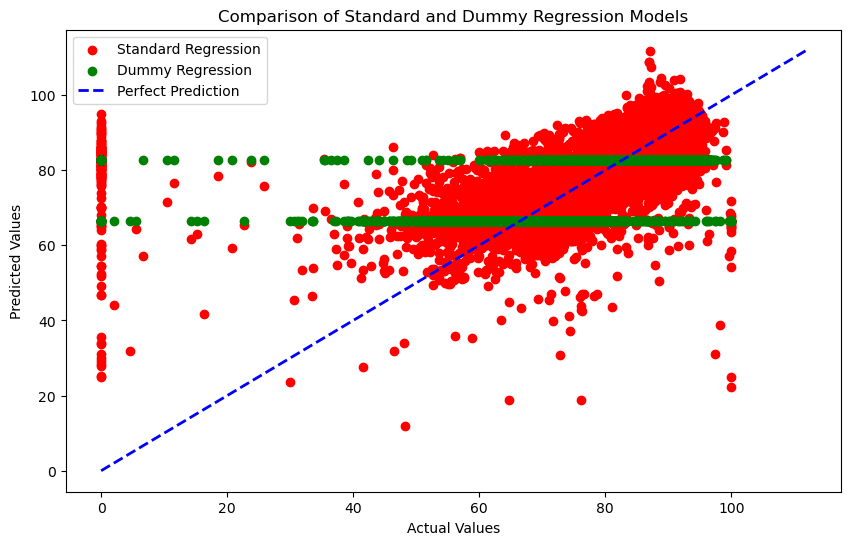

In [42]:
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()
if isinstance(y_pred, pd.Series):
    y_pred = y_pred.to_numpy()
if isinstance(y_pred_dummy, pd.Series):
    y_pred_dummy = y_pred_dummy.to_numpy()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red', label='Standard Regression')
plt.scatter(y_test, y_pred_dummy, color='green', label='Dummy Regression')

# Compute max and min values for plotting the diagonal line
max_val = max(np.max(y_test), np.max(y_pred), np.max(y_pred_dummy))
min_val = min(np.min(y_test), np.min(y_pred), np.min(y_pred_dummy))

plt.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of Standard and Dummy Regression Models')
plt.legend()
plt.show()

**Findings**

The Linear Regression model attained a SMAPE score of approximately 10% on unseen data, indicating that its predictions have a relative error of around 10% on average. This suggests that the model has about a 10% chance of inaccurately predicting the final concentrations in the gold ore recovery process. Overall, the model slightly outperformed the baseline dummy model in prediction accuracy.

## Conclusion

In conclusion, this project has unveiled crucial insights into the intricate task of predicting gold recovery from ore, shedding light on the multifaceted challenges inherent in the process. An initial observation surfaced concerning the disparities in data dimensions among the train, test, and full datasets, necessitating meticulous feature selection to ensure model compatibility across all sets. Tackling missing values emerged as a significant preprocessing hurdle, prompting the adoption of strategies such as dropping missing targets and forward filling to uphold data integrity throughout the analysis.

Furthermore, the strikingly low Mean Absolute Error (MAE) encountered during the comparison of actual and predicted recovery values in the training dataset underscores the precision of the actual values derived. Nonetheless, the absence of certain features linked to ore mining outputs in the test dataset presents a notable obstacle for model evaluation and prediction, posing a need for innovative solutions to bridge this gap effectively.

Insights garnered from the thorough analysis of metal concentration trends throughout the purification process provide valuable operational perspectives, offering a deeper understanding of the efficacy of each purification stage. Additionally, the consistency observed in particle feed size distributions between the train and test datasets assures robustness in model training and evaluation, affirming the reliability of the dataset for predictive modeling purposes.

The development and evaluation of various regression models, including Linear Regression, Decision Tree Regressor, and Random Forest Regressor, yielded promising results, highlighting the potential of machine learning in this domain. Among these models, the Linear Regression model stood out for its balanced performance in both accuracy and computational efficiency. Its satisfactory Symmetric Mean Absolute Percentage Error (SMAPE) score of around 10% on unseen data indicates a relative error of approximately 10% when predicting gold recovery targets.

Looking ahead, the continual refinement of models and strategies based on real-world feedback will be pivotal in further enhancing predictive accuracy and operational efficiency in gold recovery processes. Embracing a dynamic approach to model development and deployment will enable the seamless integration of cutting-edge technologies into industrial practices, driving continuous improvement and innovation in the field of ore mining and processing.